# Remake predictor example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
from classes.SAMMed2DClass import SAMMed2DInferer
from utils.base_classes import Points, Boxes2d

import utils.analysisUtils as anUt
import utils.promptUtils as prUt
from utils.imageUtils import read_im_gt


# Obtain model, image, gt
device = 'cuda'
sammed2d_checkpoint_path = "/home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth"

sammed2d_inferer = SAMMed2DInferer(sammed2d_checkpoint_path, device)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


True
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth


In [4]:
image = cv2.imread('/home/t722s/Desktop/UniversalModels/OtherRepos/SAM-Med2D/data_demo/images/amos_0507_31.png')

# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.show()
# image.shape

image = image[:,:,0]
image_3d = np.zeros((1, image.shape[0], image.shape[1]))
image_3d[0] = image

# Test points

input_point = np.array([[162, 127]])
input_label = np.array([1])
input_point_3d = np.array([[0, 127, 162]])
prompt = Points({'coords': input_point_3d,'labels': input_label})

segmentation = sammed2d_inferer.predict(image_3d, prompt)

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


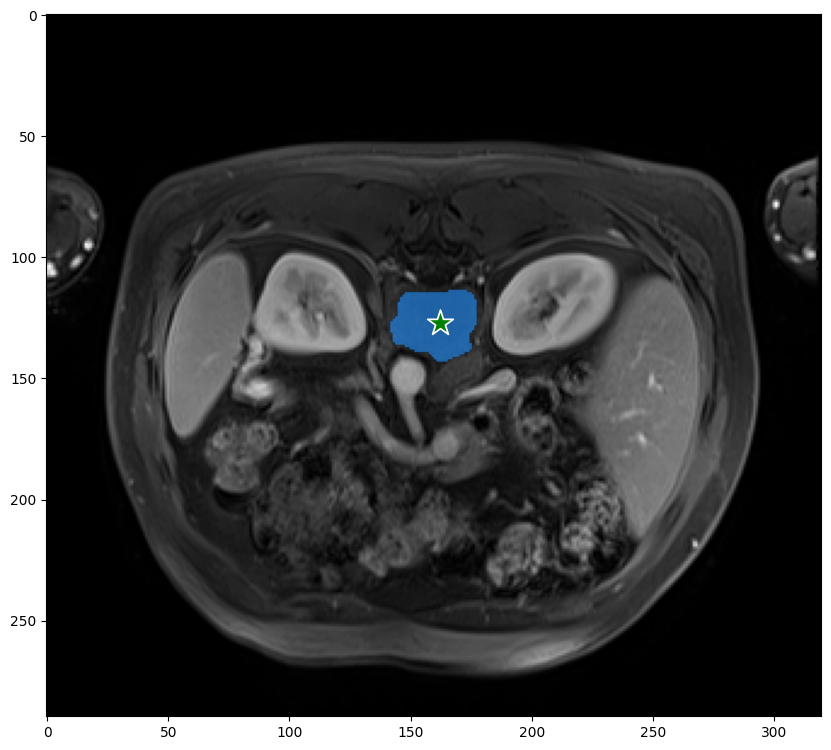

In [5]:
seg_2d = segmentation[0]

plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
show_mask(seg_2d, plt.gca())
plt.show()  


# OPTIMISING

In [27]:
import torch
input_point1 = np.array([[150, 130]])
input_label1 = np.array([0])
input_points = np.concatenate((input_point, input_point1))
input_labels = np.concatenate((input_label, input_label1))
input_point1_3d = np.array([[0, 130, 150]])

worst_slice_idx = 0
prev_masks_dict = {worst_slice_idx: torch.sigmoid(sammed2d_inferer.slice_lowres_dict[worst_slice_idx]).squeeze().cpu().numpy()}
prompt = Points({'coords': np.concatenate((input_point_3d, input_point1_3d)), 'labels': input_labels})

segmentation = sammed2d_inferer.predict(image_3d, prompt, mask_dict = prev_masks_dict)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00, 74.45it/s]


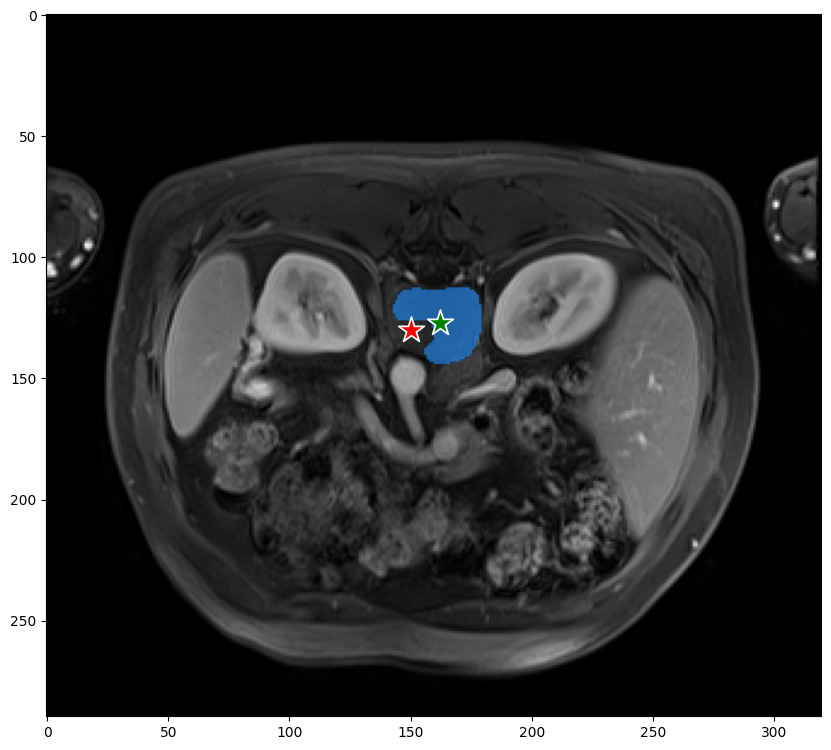

In [28]:
seg_2d = segmentation[0]

plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
show_points(input_points, input_labels, plt.gca())
plt.axis('on')
show_mask(seg_2d, plt.gca())
plt.show()  


# TESTING BOXES

In [26]:
image = cv2.imread('/home/t722s/Desktop/UniversalModels/OtherRepos/SAM-Med2D/data_demo/images/s0114_111.png')
image = image[:,:,0]
image_3d = np.zeros((128, image.shape[0], image.shape[1]))
image_3d[0] = image

input_box = np.array([89,43,113,64])
prompt = Boxes2d({0: [89,43,113,64]})


In [28]:
segmentation = sammed2d_inferer.predict(image_3d, prompt)

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


In [36]:
import pickle
with open('/home/t722s/Desktop/test/bboxmask.pkl', 'rb') as f:
    seg_orig = pickle.load(f)
seg_orig = seg_orig[0]

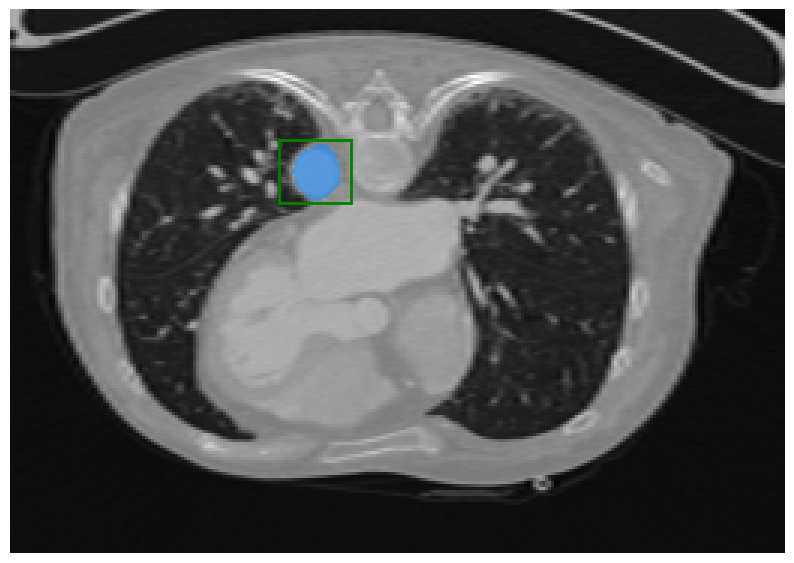

In [31]:
seg_2d = segmentation[0]

plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
show_box(input_box, plt.gca())
plt.axis('off')
show_mask(seg_2d, plt.gca())
plt.show()  
